# Analysis

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Import data

In [2]:
data = pd.read_csv("Tripadvisordata_final.csv")

data= data.round(2)

list = []
for i in range(len(data["Type of food"])):  
    if "<div" in str(data["Type of food"][i]):
        list.append(i)
    
#print(list)
for i in list:
    data["Type of food"][i] = "Missing"


# set color "Tripadvisor-green"
green_color = "#00AF87"


/Users/michaelemcken/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


## Generates and saves summary table of data

In [3]:
sum_tab = data.describe()
sum_tab.to_csv("Summary_tab.csv")

# Make copy of dataset containing only restaurants in greater-Copenhagen 

In [4]:
mod_df = data.copy()
# Obs filter restaurants more than 10 km from Kgs. Nytorv
mod_df = data[data["Distance from Kgs. Nytorv (m)"]<10000] # 10 km from Kgs. Nytorv (m)



## OLS estmation of full ranking as funktion if distance, price class and number of reviews

In [5]:
# Subset data
reg_df = mod_df.loc[mod_df['Price class numeric'] != 99] 
reg_df = reg_df.loc[mod_df['Full ranking'] != 2000] 
reg_df = reg_df[pd.to_numeric(reg_df['Distance from Kgs. Nytorv (m)'], errors='coerce').notnull()]

# Estimate model
reg1 = sm.OLS(endog=reg_df['Full ranking'], exog=reg_df[['Distance from Kgs. Nytorv (m)', 'Price class numeric', "Number of reviews"]], missing='drop')
results = reg1.fit()

#Print to tex format
beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open('myreg.tex', 'w') # save
f.write(beginningtex)
f.write(results.summary().as_latex())
f.write(endtex)
f.close()

print(results.summary())



                            OLS Regression Results                            
Dep. Variable:           Full ranking   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     1771.
Date:                Fri, 30 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:01:48   Log-Likelihood:                -12838.
No. Observations:                1633   AIC:                         2.568e+04
Df Residuals:                    1630   BIC:                         2.570e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Distance from 

## Generate scatterplot with fitted line of ranking as function of distance to Kongens Nytorv

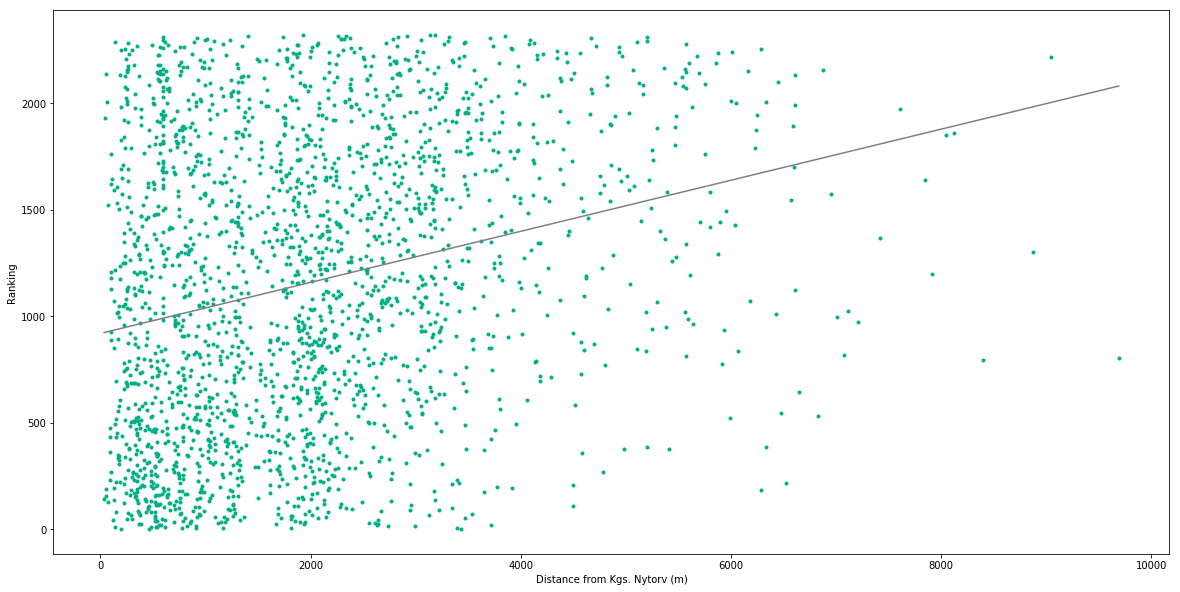

In [6]:
X = mod_df["Distance from Kgs. Nytorv (m)"]
y = mod_df["Full ranking"]

fig, ax = plt.subplots()
ax.scatter(X, y, marker='.', color = green_color) #choose scatter plot
plt.gcf().set_size_inches((20, 10)) #set size of graph area

# add fitted line
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='grey')

ax.set_xlabel('Distance from Kgs. Nytorv (m)')
ax.set_ylabel('Ranking')
ax.set_facecolor('white') # change background color

plt.savefig('scatter_fit1.jpeg')
plt.show()





## Generate histogram over distance to Kongens Nytorv

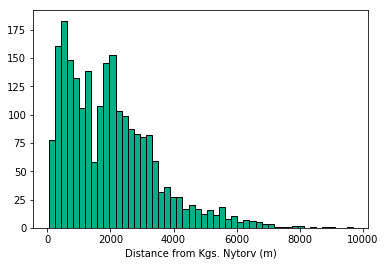

In [7]:
fig, ax = plt.subplots()
    
# Draw the plot
ax.hist(X,color = green_color , bins= 50, edgecolor = 'black')
ax.set_xlabel('Distance from Kgs. Nytorv (m)')
ax.set_facecolor('white')
plt.savefig('distplot.png') # save
plt.show()


## OLS estimation for servicelevel ranking

In [8]:
# Make dataset only of service is not missing

service_df = mod_df.dropna(subset = ["Service"])
# Make ranking system
service_df["Reverse ranking on list"] = (-1)*service_df["Ranking on list"]

# sort on rating, ranking on list and number of reviews
service_df = service_df.sort_values(by=["Service", "Reverse ranking on list", "Number of reviews"])

# Add ranking
service_df["Full ranking Service"] = range(1,len(service_df["Number of reviews"])+1)

# OLS 
reg2 = sm.OLS(endog=service_df['Full ranking Service'], exog=service_df[['Distance from Kgs. Nytorv (m)', 'Price class numeric', "Number of reviews"]], missing='drop')

results = reg2.fit()

# Write to tex format
beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open('myreg_service.tex', 'w')
f.write(beginningtex)
f.write(results.summary().as_latex())
f.write(endtex)
f.close()
print(results.summary())




                             OLS Regression Results                             
Dep. Variable:     Full ranking Service   R-squared:                       0.623
Model:                              OLS   Adj. R-squared:                  0.622
Method:                   Least Squares   F-statistic:                     706.3
Date:                  Fri, 30 Aug 2019   Prob (F-statistic):          4.86e-271
Time:                          12:01:49   Log-Likelihood:                -9698.9
No. Observations:                  1286   AIC:                         1.940e+04
Df Residuals:                      1283   BIC:                         1.942e+04
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

/Users/michaelemcken/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Count kitchen types 

In [9]:
# Locate all occurences of kitchen types in rows
data['Pizza'] = data['Type of food link'].str.contains('Pizza')
data['Pizza'].fillna(False, inplace=True)
data['Sushi'] = data['Type of food link'].str.contains('Sushi')
data['Sushi'].fillna(False, inplace=True)
data['Fisk og skaldyr'] = data['Type of food link'].str.contains('Fisk og skaldyr')
data['Fisk og skaldyr'].fillna(False, inplace=True)
data['Thai'] = data['Type of food link'].str.contains('Thai')
data['Thai'].fillna(False, inplace=True)
data['Café'] = data['Type of food link'].str.contains('Café')
data['Café'].fillna(False, inplace=True)
data['Italiensk'] = data['Type of food link'].str.contains('Italiensk')
data['Italiensk'].fillna(False, inplace=True)
data['Indisk'] = data['Type of food link'].str.contains('Indisk')
data['Indisk'].fillna(False, inplace=True)
data['Steakhouse'] = data['Type of food link'].str.contains('Steakhouse')
data['Steakhouse'].fillna(False, inplace=True)
data['Mexicansk'] = data['Type of food link'].str.contains('Mexicansk')
data['Mexicansk'].fillna(False, inplace=True)
data['Thai'] = data['Type of food link'].str.contains('Thai')
data['Thai'].fillna(False, inplace=True)

type_mad_df = data[['Location','Ranking on list','Price class numeric','Restaurant','Postal code','Pizza','Sushi','Fisk og skaldyr','Thai','Café','Italiensk','Indisk','Mexicansk','Steakhouse']].copy()
type_mad_df.count() #count

Location               2320
Ranking on list        2170
Price class numeric    2320
Restaurant             2320
Postal code            2317
Pizza                  2320
Sushi                  2320
Fisk og skaldyr        2320
Thai                   2320
Café                   2320
Italiensk              2320
Indisk                 2320
Mexicansk              2320
Steakhouse             2320
dtype: int64

In [10]:
type_mad_df.to_csv("type_mad_df.csv") # Save dataframe to csv

## Generate data for barcharts 

In [11]:
food_df = pd.read_csv("type_mad_df.csv")
food_df.head()

,Unnamed: 0,Location,Ranking on list,Price class numeric,Restaurant,Postal code,Pizza,Sushi,Fisk og skaldyr,Thai,Café,Italiensk,Indisk,Mexicansk,Steakhouse
0,0,"55.65107,12.50931",2148.0,99,Burger King,2450,False,False,False,False,False,False,False,False,False
1,1,"55.67788,12.591933",2146.0,99,Almanac,,False,False,False,False,False,False,False,False,False
2,2,"55.6679,12.54941",2143.0,2,Star Midnight Kebab-Grill,,False,False,False,False,False,False,False,False,False
3,3,"55.67502,12.580593",2137.0,99,Sunset Boulevard,1570,False,False,False,False,False,False,False,False,False
4,4,"55.72732,12.524776",2104.0,2,Dwaraka Indisk Restaurant,2860,False,False,False,False,False,False,True,False,False


In [12]:
print(type(food_df["Postal code"][1]))

#Copenhagen central post codes 
kbhK =[]
for i in range(1000,1500):
    kbhK.append(str(i))

kbhV = []
for i in range(1500, 1800):
    kbhV.append(str(i))
    
frb = []
for i in range(1800, 2100):
    frb.append(str(i))

food_df["Postal code"] = food_df["Postal code"].str.strip() # remove spaces in strings




<class 'str'>


## Generate Data with city areas from postcodes

In [13]:
# remove all with no postal code
food_df =  food_df.dropna(subset = ["Postal code"])

#List of kitchens
list_ = ["Pizza", "Sushi", "Fisk og skaldyr", "Thai", "Café", "Italiensk", "Indisk", "Mexicansk", "Steakhouse"]
en_list_ = ["Pizza", "Sushi", "Seafood", "Thai", "Café", "Italian", "Indian", "Mexican", "Steakhouse"]

# change booleans to 1/0
for x in list_:
    app = []
    for i in food_df[x]:
        if i == True:
            app.append(1)
        else:
            app.append(0)
    #print(app)
    food_df[str(x)]=app

Area = []
# make areas   
for i in food_df["Postal code"]: 
    if i in kbhK:
        Area.append("kbh k")
    elif i in kbhV:
         Area.append("kbh v")
    elif i in frb:
        Area.append("frb.")
    elif i ==  "2100":
        Area.append("kbh ø")
    elif i == "2200":
        Area.append("kbh n")
    elif i == "2300":
        Area.append("kbh s")
    elif i == "2450":
        Area.append("kbh sv")
    elif i == "2400":
        Area.append("valby")
    elif i == "2500":
        Area.append("valby")
    else:
        Area.append("andet")

food_df["City Area"] = Area
food_df.to_csv("data_food_poscode2.csv")

## Generate table of percentage of kithcens in city areas

In [14]:
#loading new data with postal codes
data_food = pd.read_csv('data_food_poscode2.csv')
data_food.head()

,Unnamed: 0,Unnamed: 0.1,Location,Ranking on list,Price class numeric,Restaurant,Postal code,Pizza,Sushi,Fisk og skaldyr,Thai,Café,Italiensk,Indisk,Mexicansk,Steakhouse,City Area
0,0,0,"55.65107,12.50931",2148.0,99,Burger King,2450,0,0,0,0,0,0,0,0,0,kbh sv
1,1,1,"55.67788,12.591933",2146.0,99,Almanac,NaN,0,0,0,0,0,0,0,0,0,andet
2,2,2,"55.6679,12.54941",2143.0,2,Star Midnight Kebab-Grill,NaN,0,0,0,0,0,0,0,0,0,andet
3,3,3,"55.67502,12.580593",2137.0,99,Sunset Boulevard,1570,0,0,0,0,0,0,0,0,0,kbh v
4,4,4,"55.72732,12.524776",2104.0,2,Dwaraka Indisk Restaurant,2860,0,0,0,0,0,0,1,0,0,andet


In [15]:
#saving csv for folio map plotting
data.to_csv('test_map_pizza.csv')

In [16]:
# Group data by city area
g = data_food.groupby('City Area')
size = g.size()
size = pd.DataFrame(size)
size.columns = ["Total"] # make 
print(size)

           Total
City Area       
andet        402
frb.         223
kbh k        698
kbh n        213
kbh s        163
kbh sv        32
kbh v        391
kbh ø        151
valby         44


In [17]:
df_grp_area = data_food.groupby('City Area')['Pizza','Sushi','Fisk og skaldyr','Thai','Café','Italiensk','Indisk','Mexicansk','Steakhouse'].sum()
df_grp_area

,Pizza,Sushi,Fisk og skaldyr,Thai,Café,Italiensk,Indisk,Mexicansk,Steakhouse
City Area,,,,,,,,,
andet,28,14,8,11,39,42,11,4,1
frb.,13,12,0,11,23,25,9,4,3
kbh k,31,18,36,14,75,81,10,13,11
kbh n,16,4,5,9,23,23,5,1,0
kbh s,17,14,4,5,14,22,7,1,3
kbh sv,3,1,0,1,3,3,1,0,1
kbh v,21,12,6,13,32,48,10,5,13
kbh ø,6,7,4,3,15,17,3,4,2
valby,6,5,2,1,6,5,1,1,0


In [18]:
#joining the two dataframes to get the total column
df_grp_area = pd.merge(df_grp_area, size, left_on='City Area', right_on='City Area')
df_grp_area

,Pizza,Sushi,Fisk og skaldyr,Thai,Café,Italiensk,Indisk,Mexicansk,Steakhouse,Total
City Area,,,,,,,,,,
andet,28,14,8,11,39,42,11,4,1,402
frb.,13,12,0,11,23,25,9,4,3,223
kbh k,31,18,36,14,75,81,10,13,11,698
kbh n,16,4,5,9,23,23,5,1,0,213
kbh s,17,14,4,5,14,22,7,1,3,163
kbh sv,3,1,0,1,3,3,1,0,1,32
kbh v,21,12,6,13,32,48,10,5,13,391
kbh ø,6,7,4,3,15,17,3,4,2,151
valby,6,5,2,1,6,5,1,1,0,44


Calculating parental representation of food types in the city different areas. This is used to make a relative scale, making it possible to compare share of restaurant types across the areas. 

In [19]:
df_grp_area['p pizza'] = df_grp_area['Pizza']/df_grp_area['Total']*100
df_grp_area['p Sushi'] = df_grp_area['Sushi']/df_grp_area['Total']*100
df_grp_area['p Fisk og skaldyr'] = df_grp_area['Fisk og skaldyr']/df_grp_area['Total']*100
df_grp_area['p Thai'] = df_grp_area['Thai']/df_grp_area['Total']*100
df_grp_area['p Café'] = df_grp_area['Café']/df_grp_area['Total']*100
df_grp_area['p Italiensk'] = df_grp_area['Italiensk']/df_grp_area['Total']*100
df_grp_area['p Indisk'] = df_grp_area['Indisk']/df_grp_area['Total']*100
df_grp_area['p Mexicansk'] = df_grp_area['Mexicansk']/df_grp_area['Total']*100
df_grp_area['p Steakhouse'] = df_grp_area['Steakhouse']/df_grp_area['Total']*100

In [20]:
percent_df = df_grp_area[df_grp_area.columns[10:]] #selecting the relavant columns of the dataframe

In [21]:
#calculating a mean row, for easy comparison between city areas
percent_df_mean = percent_df.append(percent_df.mean().rename('mean_kitchen'))
percent_df_mean = percent_df_mean.round(2)
percent_df_mean

,p pizza,p Sushi,p Fisk og skaldyr,p Thai,p Café,p Italiensk,p Indisk,p Mexicansk,p Steakhouse
City Area,,,,,,,,,
andet,6.97,3.48,1.99,2.74,9.70,10.45,2.74,1.00,0.25
frb.,5.83,5.38,0.00,4.93,10.31,11.21,4.04,1.79,1.35
kbh k,4.44,2.58,5.16,2.01,10.74,11.60,1.43,1.86,1.58
kbh n,7.51,1.88,2.35,4.23,10.80,10.80,2.35,0.47,0.00
kbh s,10.43,8.59,2.45,3.07,8.59,13.50,4.29,0.61,1.84
kbh sv,9.38,3.12,0.00,3.12,9.38,9.38,3.12,0.00,3.12
kbh v,5.37,3.07,1.53,3.32,8.18,12.28,2.56,1.28,3.32
kbh ø,3.97,4.64,2.65,1.99,9.93,11.26,1.99,2.65,1.32
valby,13.64,11.36,4.55,2.27,13.64,11.36,2.27,2.27,0.00


In [22]:
percent_df.to_csv('percent på bydel.csv') # without means for map plotting
percent_df_mean.to_csv('percent på bydel_mean.csv') #with means

## Generate bar chart of mean ratings on Kitchen types

In [23]:
food_df = pd.merge(food_df, mod_df[["Restaurant","Main rating"]], on='Restaurant', how='left')


In [24]:
Pizza = []
Sushi = []
Seafood = []
Thai = []
Café = []
Italian = [] 
Indian = [] 
Mexican = []
Steakhouse = []

Lists = [Pizza, Sushi, Seafood, Thai, Café, Italian, Indian, Mexican, Steakhouse]


for i in range(6,15): 
    liste = Lists[i-6]
    for x in range(len(food_df.iloc[:,i])):
        if food_df.iloc[:,i][x] == 1: 
            #print(type(food_df.iloc[:,-1][x]))
            liste.append(food_df.iloc[:,-1][x].astype(float))


In [25]:
means = []
lenght = []
for i in Lists:
    i = [x for x in i if x.astype(str) != 'nan']
    lenght.append(len(i))
    if len(i) == 0:
        c=0
    else:
        c= (sum(i)/len(i))
    means.append(c)
   

 

In [26]:
Food_means = percentile_list = pd.DataFrame(np.column_stack([en_list_, means, lenght]), 
                               columns=['Kitchen', 'Mean Rating', 'Number of Restaurants'])

Food_means["Mean Rating"] = Food_means["Mean Rating"].str.strip()

# make ratings an rounded integer
rat = []
for i in Food_means["Mean Rating"]:
    i = i.translate({ord('.'): None}) # remove the "."
    i = i[:3] # take first three characters
    i = int(i)/100 # make integer and divide by 100
    rat.append(i) # append to list    
    
Food_means["Mean Rating"] = rat # append to dataframe

# remove the row of non-existing mexican kitchens
Food_means = Food_means.loc[Food_means['Mean Rating'] != 0.0] 
Food_means = Food_means.sort_values(by = ['Mean Rating'])

Food_means

,Kitchen,Mean Rating,Number of Restaurants
7,Mexican,3.62,33
6,Indian,3.66,60
8,Steakhouse,3.81,35
0,Pizza,3.88,125
3,Thai,3.94,68
1,Sushi,3.95,135
5,Italian,4.01,249
4,Café,4.04,222
2,Seafood,4.22,84


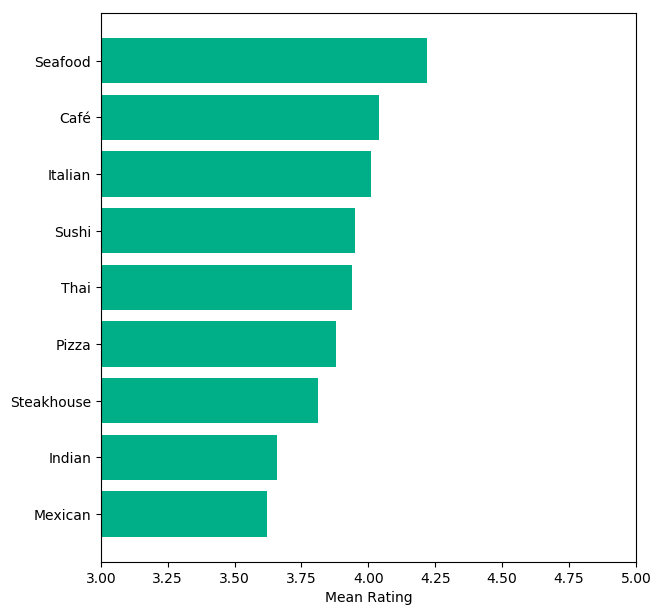

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()
plt.style.use('ggplot')
plt.gcf().set_size_inches((8, 8)) #set size of graph area
fig.tight_layout(pad=8)


# Example data
rests = [Food_means["Mean Rating"]]
y_pos = Food_means["Kitchen"]
performance = Food_means["Mean Rating"]

ax.barh(y_pos, performance, align='center', color = green_color)
#ax.set_yticks(y_pos)
#ax.set_yticklabels("Type of food")
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Mean Rating')
ax.set_xlim(3,5)
ax.yaxis.label.set_size(20)

#ax.set_title('How fast do you want to go today?')
label = [Food_means["Mean Rating"]]

plt.savefig('kitchenplot.png')


## Generate datframe on Maximum prices 

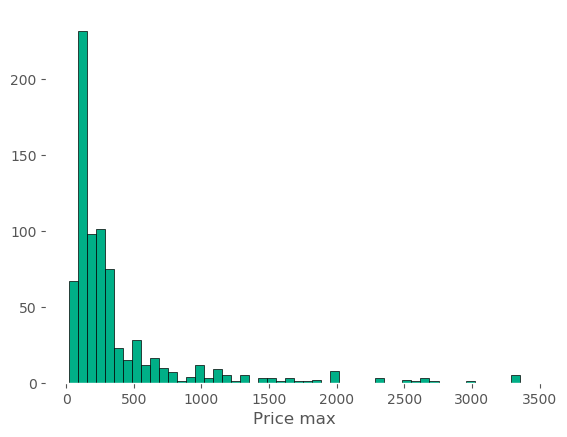

In [28]:
#creates a dataframe containing only the reastaurants with observations on Price range and converting the values to integers

price_df = data.copy()
price_df= price_df.dropna(subset = ["Price range"]) # drop observations without info on max price

# Change values on max price from object to string to integer
price_list = []
for i in price_df["Price range"]:
    price_list.append(str(i))

price_df["Price_range_2"] = price_list

price_df["Price_range_2"] = price_df["Price_range_2"].str.strip()
price_df = price_df[price_df["Price_range_2"] != ","]

price_list2 = []
for i in price_df["Price_range_2"]:
    x = i.translate({ord('.'): None})
    y = int(x)
    price_list2.append(y)

price_df["Price_range_2"] = price_list2 # add to dataframe

price_df.to_csv("price_df.csv")

# Limit the dataset
price_df = price_df[price_df["Distance from Kgs. Nytorv (m)"]<10000] # 10 km from Kgs. Nytorv (m)
price_df = price_df[price_df["Price_range_2"]<3500] # remove the most expensive

# histogram of prices
fig, ax = plt.subplots()
X = price_df["Price_range_2"]
# Draw the plot
ax.hist(X,color = green_color , bins= 50, edgecolor = 'black')
ax.set_xlabel('Price max')
ax.set_facecolor('white')
plt.savefig('priceplot.png')
plt.show()

price_df = price_df[price_df["Distance from Kgs. Nytorv (m)"]<10000] # 10 km from Kgs. Nytorv (m)



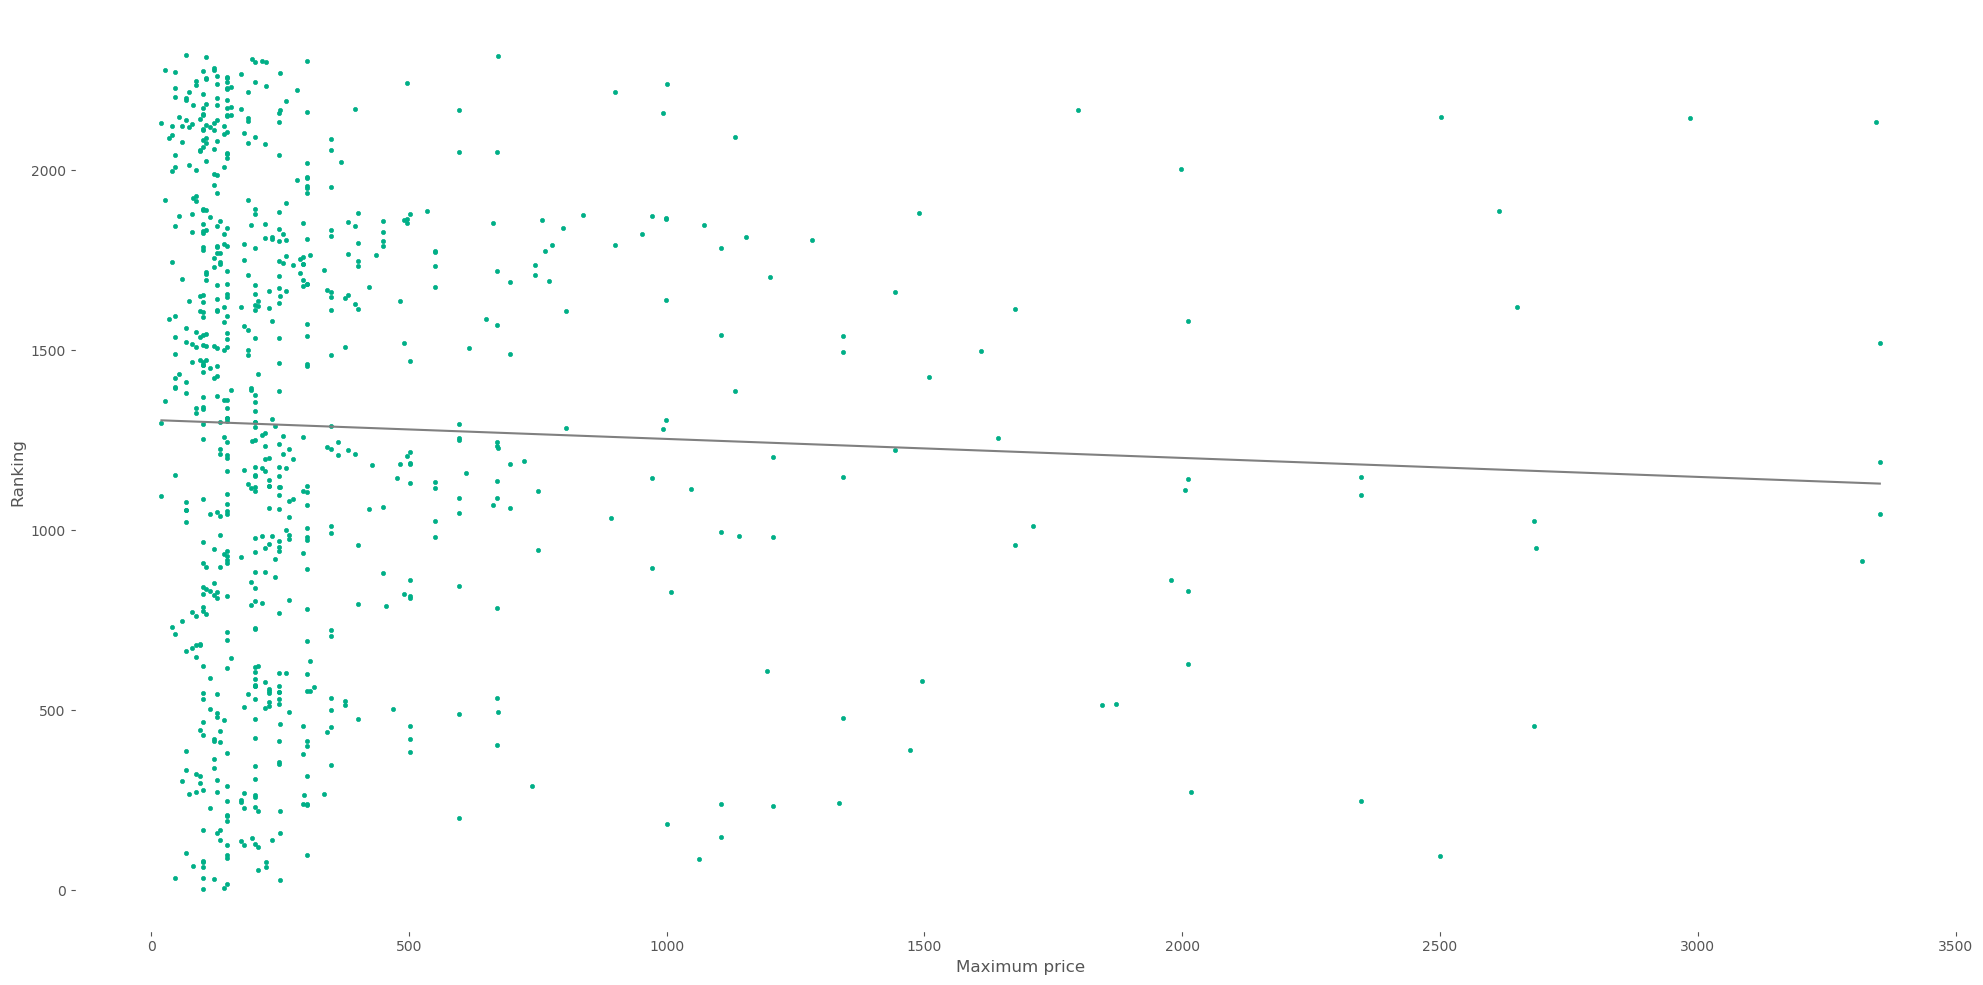

In [29]:
X = price_df["Price_range_2"]
y = price_df["Full ranking"]
 
fig, ax = plt.subplots()
ax.scatter(X, y, marker='.', color = green_color) #choose scatter plot
plt.gcf().set_size_inches((20, 10)) #set size of graph area
fig.tight_layout(pad=2)

# add fitted line
ax.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='grey')

ax.set_xlabel('Maximum price')
ax.set_ylabel('Ranking')
ax.set_facecolor('white') # change background color

plt.savefig('scatter_fit_price.jpeg')
plt.show()